In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/HaoEtAl


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
h5py                3.6.0
harmonypy           NA
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3
natsort             8.1.0
nbinom_ufunc        NA
numba               0.55.1
numpy               1.21.6
packaging           21.3
pandas   

# Parameters - B-cells

In [21]:
params = {
'harmony_vars' : ['lane', 'donor'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 55,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 27,
'n_adt_pcs' : 21,
'name_addition' : '.B.20231227.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.R

# Run pipeline - B-cells

In [5]:
adata = sc.read(paths['Original'])

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [6]:
adata.obs['celltype.l1'].value_counts()

Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64

In [7]:
adata = adata[adata.obs['celltype.l1']=='B', :]

In [8]:
adata = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, obsm=adata.obsm)

In [9]:
adata.X.sum(axis=1)

matrix([[12629.],
        [ 9590.],
        [10027.],
        ...,
        [12464.],
        [11617.],
        [12728.]], dtype=float32)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


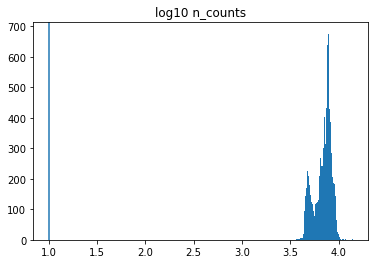

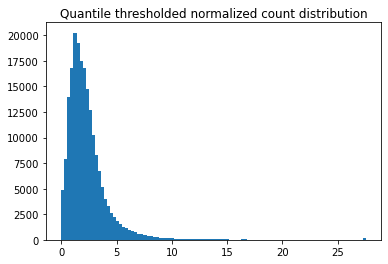

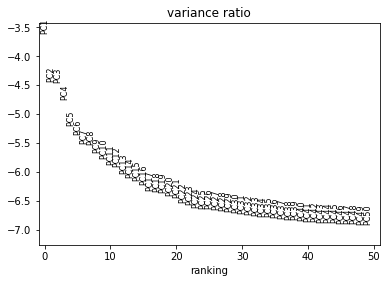

2023-12-27 16:58:35,327 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-27 16:58:49,257 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-27 16:58:49,378 - harmonypy - INFO - Iteration 1 of 20
2023-12-27 16:58:53,951 - harmonypy - INFO - Iteration 2 of 20
2023-12-27 16:58:58,544 - harmonypy - INFO - Iteration 3 of 20
2023-12-27 16:59:03,386 - harmonypy - INFO - Iteration 4 of 20
2023-12-27 16:59:07,257 - harmonypy - INFO - Iteration 5 of 20
2023-12-27 16:59:09,714 - harmonypy - INFO - Iteration 6 of 20
2023-12-27 16:59:11,787 - harmonypy - INFO - Iteration 7 of 20
2023-12-27 16:59:13,668 - harmonypy - INFO - Iteration 8 of 20
2023-12-27 16:59:15,547 - harmonypy - INFO - Converged after 8 iterations
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = coun

In [10]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [11]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [12]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

In [13]:
params['n_neighbors']

30

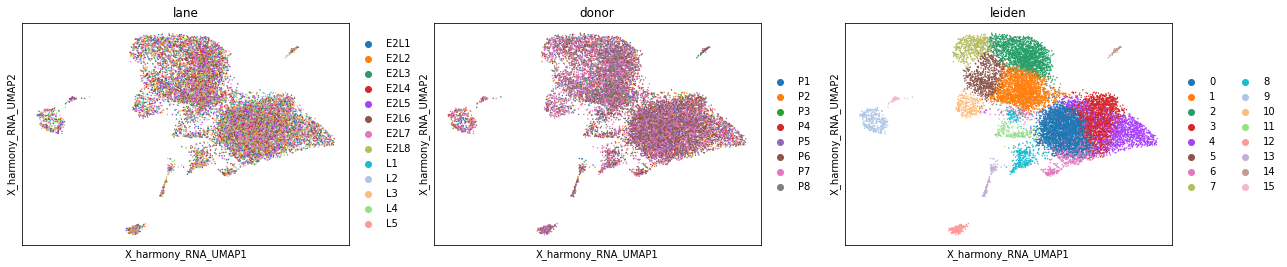

In [14]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony', key_added=None)
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [15]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [16]:
adata_filt = adata[adata_RNA_c.obs.index, ]

In [17]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((13800, 20957), (13800, 2000), (13800, 20957))

In [18]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.FiltForcNMF.h5ad'

In [19]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.FiltForcNMF', '.h5ad'].
Only considering the two last: ['.FiltForcNMF', '.h5ad'].


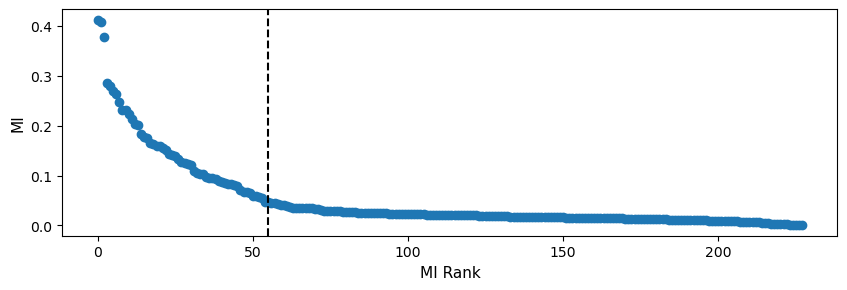

In [22]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [23]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


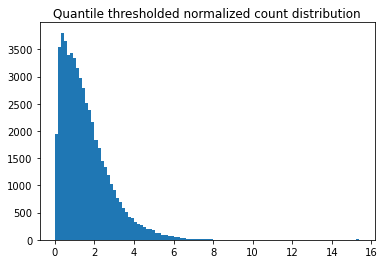

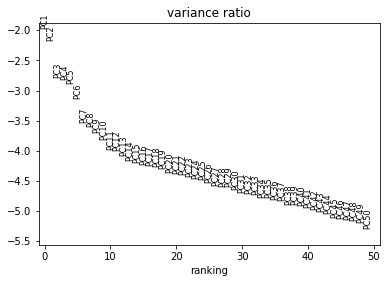

2023-12-27 17:02:14,355 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-27 17:02:27,200 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-27 17:02:27,319 - harmonypy - INFO - Iteration 1 of 20
2023-12-27 17:02:31,601 - harmonypy - INFO - Iteration 2 of 20
2023-12-27 17:02:35,836 - harmonypy - INFO - Iteration 3 of 20
2023-12-27 17:02:40,088 - harmonypy - INFO - Iteration 4 of 20
2023-12-27 17:02:43,789 - harmonypy - INFO - Iteration 5 of 20
2023-12-27 17:02:46,018 - harmonypy - INFO - Iteration 6 of 20
2023-12-27 17:02:48,071 - harmonypy - INFO - Iteration 7 of 20
2023-12-27 17:02:49,760 - harmonypy - INFO - Iteration 8 of 20
2023-12-27 17:02:51,462 - harmonypy - INFO - Iteration 9 of 20
2023-12-27 17:02:52,963 - harmonypy - INFO - Iteration 10 of 20
2023-12-27 17:02:54,474 - harmonypy - INFO - Iteration 11 of 20
2023-12-27 17:02:55,982 - harmonypy - INFO - Converged after 11 iterations


In [24]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [25]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [26]:
adata_ADT_c

AnnData object with n_obs × n_vars = 13800 × 55
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'celltype.l3.merged', 'n_counts'
    var: 'features', 'feature_types', 'Clone', 'Specificity', 'Name_ADT_Fixed', 'Gene_ADT_Fixed', 'Clone_ADT_Fixed', 'features_renamed', 'mean', 'std', 'MI', 'MI_Rank', 'MI_diff', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap', 'X_pca_harmony'
    obsp: 'distances', 'connectivities'

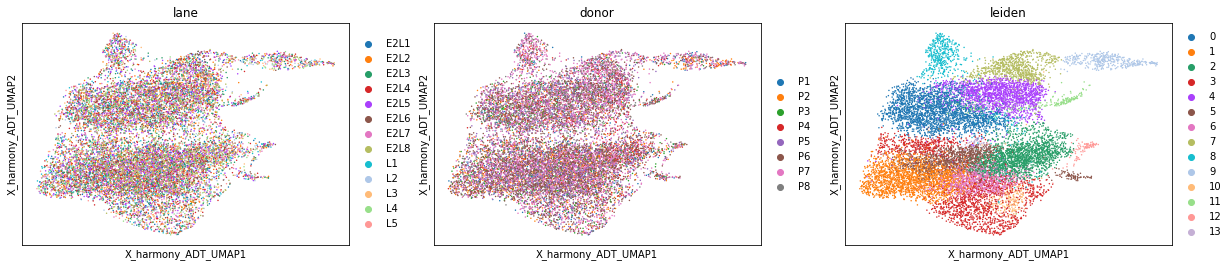

In [27]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [28]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.

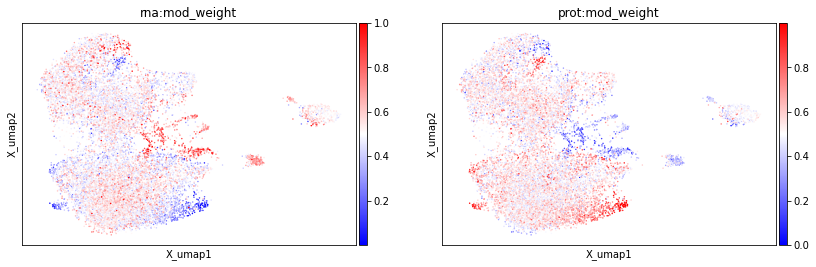

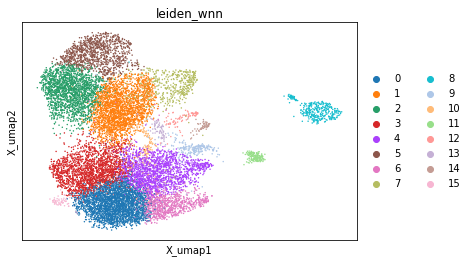

In [29]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [30]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [31]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

In [32]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

In [33]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,IL4R,BTG1,CXCR4,TCL1A,TXNIP,APLP2,PLPP5,FCER2,MEF2C,KCNG1,STK17A,YBX3,SELL,SESN1,CNTNAP2,ADK,PIK3IP1,SKAP1,ZBTB16,CD200
1,GPR183,CCDC50,LINC01857,MARCKS,TNFRSF13B,TCF4,TBC1D9,AIM2,MALAT1,CLECL1,CD1C,FCRL2,CSGALNACT1,CD82,GPM6A,TFEC,VOPP1,CD24,ZBTB20,SPIB
2,LINC01781,AIM2,MALAT1,COCH,RPS4X,SCIMP,TEX9,SHISA8,SSPN,LYPLAL1,LTB,TCF7,BTNL9,HSPA8,ARID5B,NCOA7,RNGTT,ANK3,MARCKS,DAAM1
3,TCL1A,FCER2,BTG1,PLPP5,CXCR4,IL4R,CLEC2D,CHI3L2,ZNF318,CD72,STK17A,APLP2,STX7,COL19A1,FCRL1,MEF2C,BACH2,KCNG1,ADAM28,HLA-DRB1
4,TCL1A,YBX3,NEIL1,TMSB10,JUNB,PCDH9,BCL7A,CXCR4,BTG1,CD9,MACROD2,DUSP1,CD72,SOX4,VPREB3,CCDC191,PLD4,CAMK2D,PPP1R14A,TAPT1
5,ITGB1,AIM2,S100A10,CPNE5,ANXA2,HSPA8,CRIP1,SSPN,TNFRSF13B,LYPLAL1,JPT1,DAAM1,CD82,GAPDH,TAGLN2,TEX9,HIPK2,ANXA4,DYNLL1,COCH
6,BTG1,CXCR4,KLF2,TCL1A,APLP2,CD69,H1FX,TSC22D3,FYB1,TXNIP,LYZ,YBX3,JUN,MEF2C,PLPP5,JUND,DUSP1,FOS,S100A9,CLEC2D
7,MS4A1,EMP3,CIB1,MALAT1,ZEB2,DAPP1,HLA-DRB1,FCRL3,FGR,MPP6,B4GALT1,FCRL5,POU2F2,PLAC8,TNFRSF1B,CD84,TMSB4X,PLEK,RGS2,ITGAX
8,SPCS2,PPIB,SSR3,SEC61B,SPCS1,UBE2J1,SELENOS,ITM2C,SUB1,SEC11C,MZB1,LMAN1,FKBP11,PDIA4,TXNDC5,CLPTM1L,OSTC,LMAN2,P4HB,SSR4
9,TYROBP,ANXA1,SRGN,FYB1,FCER1G,CST3,FCN1,AIF1,S100A4,S100A11,HCST,MT-CO2,MT-CO3,MT-ND1,ITGB2,SAMHD1,IL7R,CD14,IL32,MT-ND3


In [34]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,AB_CD305,AB_CD200,AB_CD73,AB_CD72,AB_CD124,AB_CD272,AB_CD22,AB_CD31,AB_CD275-2,AB_IgD
1,AB_CD45RB,AB_CD45RA,AB_CD24,AB_CD44-2,AB_CD25,AB_CD1c,AB_CD44-1,AB_IgM,AB_CD27-1,AB_CD52
2,AB_CD18,AB_CD49d,AB_CD25,AB_CD29,AB_CD35,AB_CD73,AB_CD45RB,AB_CD11b-2,AB_CD27-1,AB_CD45RA
3,AB_CD72,AB_CD21,AB_CD305,AB_IgD,AB_CD45-2,AB_CD22,AB_CD268,AB_CD196,AB_CD47,AB_HLA-DR
4,AB_CD72,AB_IgD,AB_CD38-2,AB_CD81,AB_CD38-1,AB_CD275-2,AB_IgM,AB_CD305,AB_Integrin-7,AB_CD79b
5,AB_CD99,AB_CD18,AB_CD95,AB_CD49d,AB_CD44-1,AB_CD27-1,AB_CD45RA,AB_CD45RB,AB_CD29,AB_CD44-2
6,AB_CD124,AB_CD11c,AB_CD200,AB_IgD,AB_CD275-2,AB_CD172a,AB_CD307c,AB_CD43,AB_HLA-DR,AB_CD86
7,AB_CD20,AB_CD307c,AB_CD19,AB_CD11c,AB_CD172a,AB_CD164,AB_CD48,AB_CD22,AB_CD52,AB_CD95
8,AB_CD86,AB_CD43,AB_CD71,AB_CD38-2,AB_CD38-1,AB_CD27-1,AB_CD49d,AB_CD29,AB_CD99,AB_CD95
9,AB_CD72,AB_CD22,AB_CD200,AB_CD20,AB_CD305,AB_IgD,AB_CD47,AB_CD124,AB_CD268,AB_CD31


In [35]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [36]:
paths['WNN_UMAP']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [37]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [38]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [39]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [40]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [41]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


# Parameters - Myeloid cells

In [61]:
params = {
'harmony_vars' : ['lane', 'donor'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 75,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 29,
'n_adt_pcs' : 21,
'name_addition' : '.Myeloid.20231227.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_mul

# Run pipeline - Myeloid cells

In [62]:
adata = sc.read(paths['Original'])

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [63]:
adata.obs['celltype.l1'].value_counts()

Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64

In [64]:
adata = adata[adata.obs['celltype.l1'].isin(['Mono', 'DC']), :]

In [65]:
adata = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, obsm=adata.obsm)

In [66]:
adata.X.sum(axis=1)

matrix([[13810.],
        [13891.],
        [14845.],
        ...,
        [15549.],
        [14949.],
        [12777.]], dtype=float32)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


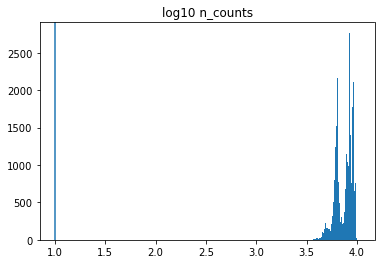

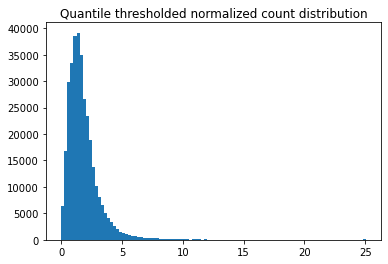

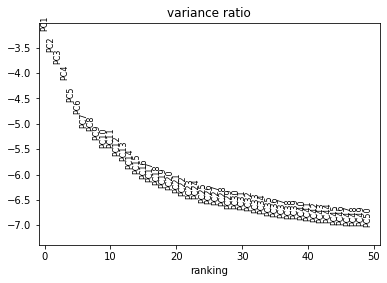

2023-12-27 17:36:54,715 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-27 17:37:19,105 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-27 17:37:19,565 - harmonypy - INFO - Iteration 1 of 20
2023-12-27 17:37:39,417 - harmonypy - INFO - Iteration 2 of 20
2023-12-27 17:37:59,355 - harmonypy - INFO - Iteration 3 of 20
2023-12-27 17:38:19,319 - harmonypy - INFO - Converged after 3 iterations
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [67]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [68]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [69]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

In [70]:
params['n_neighbors']

30

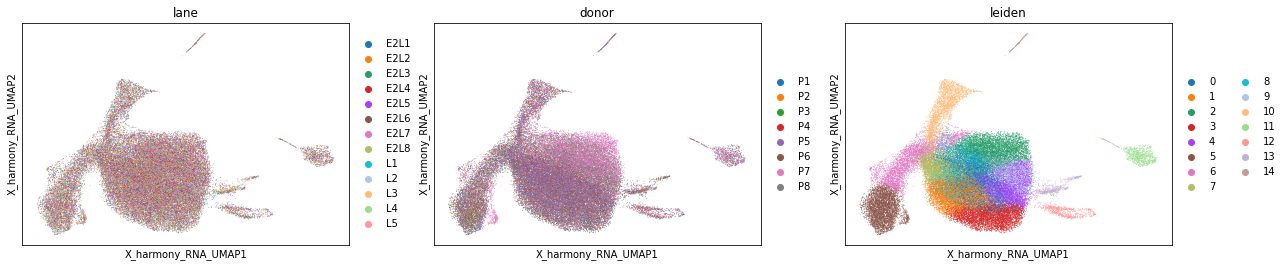

In [71]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony', key_added=None)
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [72]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [73]:
adata_filt = adata[adata_RNA_c.obs.index, ]

In [74]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((52599, 20957), (52599, 2000), (52599, 20957))

In [75]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.FiltForcNMF.h5ad'

In [76]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.FiltForcNMF', '.h5ad'].
Only considering the two last: ['.FiltForcNMF', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


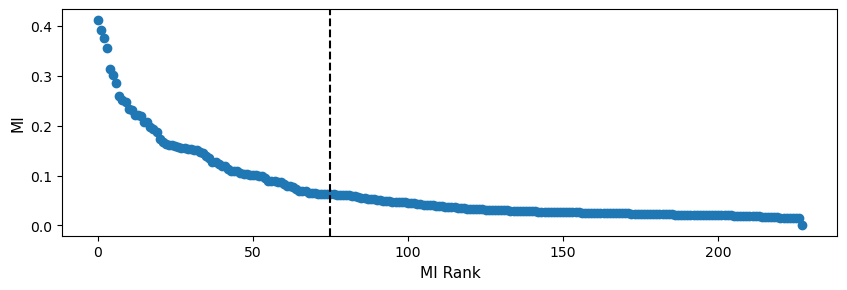

In [77]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [78]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


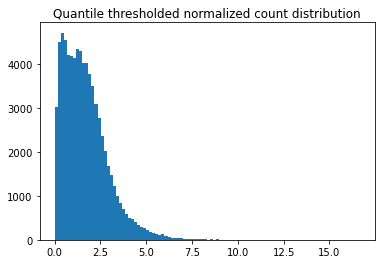

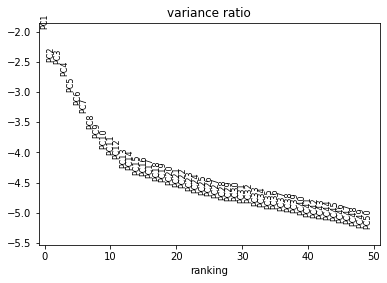

2023-12-27 17:44:59,174 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-27 17:45:22,845 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-27 17:45:23,302 - harmonypy - INFO - Iteration 1 of 20
2023-12-27 17:45:43,420 - harmonypy - INFO - Iteration 2 of 20
2023-12-27 17:46:03,910 - harmonypy - INFO - Iteration 3 of 20
2023-12-27 17:46:24,095 - harmonypy - INFO - Converged after 3 iterations


In [79]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [80]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [81]:
adata_ADT_c

AnnData object with n_obs × n_vars = 52599 × 75
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'celltype.l3.merged', 'n_counts'
    var: 'features', 'feature_types', 'Clone', 'Specificity', 'Name_ADT_Fixed', 'Gene_ADT_Fixed', 'Clone_ADT_Fixed', 'features_renamed', 'mean', 'std', 'MI', 'MI_Rank', 'MI_diff', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap', 'X_pca_harmony'
    obsp: 'distances', 'connectivities'

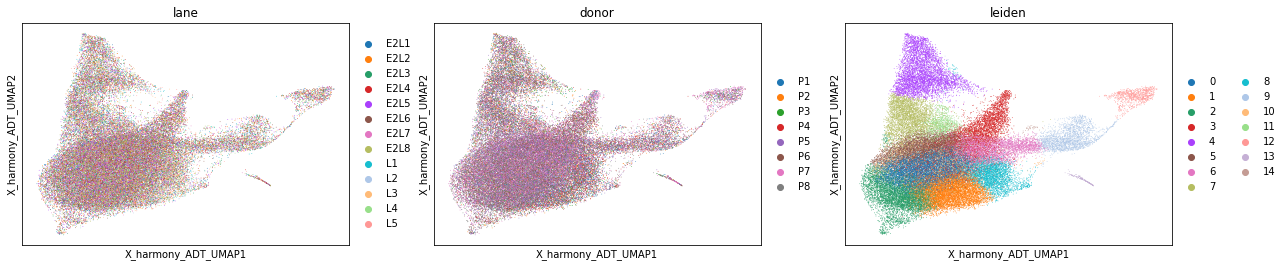

In [82]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [83]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.

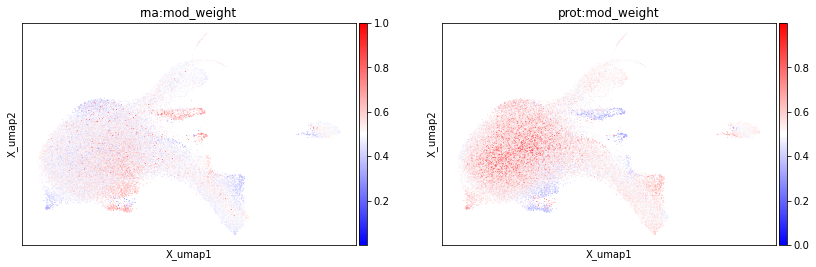

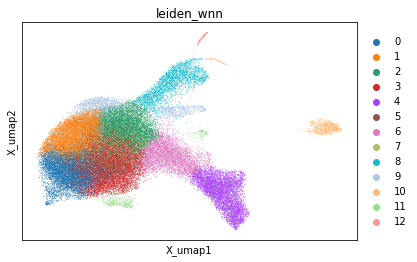

In [84]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [85]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [86]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

In [87]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

In [88]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,S100A8,S100A9,NAMPT,RGS2,FOS,CSF3R,MNDA,DUSP1,S100A12,NCF1,MT-ND2,VNN2,LRRK2,RBP7,SRGN,SLC11A1,SELL,SLC2A3,IER2,SMCHD1
1,S100A9,VCAN,LYZ,S100A8,S100A12,PLBD1,PADI4,MNDA,SELL,MEGF9,ITGAM,HMGB2,CD36,QPCT,VIM,SLC2A3,EMB,CES1,CD14,RNASE2
2,LYZ,LGALS2,F13A1,PID1,S100A10,MALAT1,AHNAK,RPLP0,LMNA,KCTD12,ID2,MS4A6A,RPS4X,YBX3,CPVL,CD99,HLA-DMB,MT-CYB,IER5L,CCR2
3,NFKBIA,TNFAIP3,SOD2,NFKBIZ,ZFP36,PNRC1,SRGN,IL1B,G0S2,PDE4B,PPP1R15A,CD83,ATP2B1-AS1,MARCKS,BCL2A1,NLRP3,CCL3,IER3,CD44,NFKBID
4,FCGR3A,LST1,RPS19,AIF1,NAP1L1,MS4A7,IFITM2,DRAP1,TCF7L2,CDKN1C,MTSS1,SMIM25,HES4,RHOC,CFD,IFITM3,KLF2,LRRC25,SPN,CTSC
5,IFI44L,XAF1,RNF213,IFI44,IFI6,MX1,PARP14,MX2,EPSTI1,LY6E,FOS,EIF2AK2,OAS2,NEAT1,OAS3,STAT1,LAP3,ISG15,SIGLEC1,HERC5
6,HLA-DPA1,HLA-DRA,CD74,HLA-DPB1,HLA-DRB1,HLA-DRB5,FTL,AIF1,CST3,HLA-DMA,PSME2,LIPA,ABI3,MARCKS,CD52,HLA-DQB1,CSF1R,HLA-DQA1,IFITM3,SASH1
7,LYZ,NEAT1,CD14,AHNAK,FOS,VCAN,MS4A6A,KCTD12,LGALS2,CD99,ZFP36L2,CEBPD,MNDA,CSF3R,YBX3,CD36,S100A10,USP15,MYADM,NAIP
8,CD74,HLA-DRA,HLA-DRB5,HLA-DRB1,HLA-DMA,RPS4X,RPSA,HLA-DPA1,RPLP0,HLA-DPB1,HLA-DQB1,HLA-DQA1,RPS19,CST3,FCER1A,HLA-DMB,CLEC10A,PPA1,ARL4C,CIITA
9,NRGN,LYZ,CAVIN2,PF4,SPARC,GNG11,TUBB1,CLU,PPBP,MAP3K7CL,HIST1H2AC,VCAN,CCL5,PRKAR2B,TREML1,C2orf88,CD14,GP9,ITGA2B,MMD


In [89]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,AB_CD55,AB_CD11b-2,AB_CD11b-1,AB_CD44-1,AB_CD35,AB_CD45RO,AB_CD57,AB_CD93,AB_CD59,AB_CD354
1,AB_CD35,AB_CD64,AB_CD155,AB_CD38-1,AB_CD99,AB_CD38-2,AB_CD93,AB_CD11b-2,AB_CD205,AB_CD49a
2,AB_CD163,AB_CD44-2,AB_CD155,AB_CD99,AB_CLEC12A,AB_CD64,AB_CD36,AB_CD63,AB_CD31,AB_CD205
3,AB_CD11b-2,AB_CD11b-1,AB_CD14-1,AB_CD93,AB_CD55,AB_CD35,AB_CD354,AB_CD18,AB_CD49a,AB_CD45RO
4,AB_CD49d,AB_CD31,AB_CD102,AB_CD16,AB_CX3CR1,AB_CD52,AB_CD45-2,AB_CD47,AB_CD172a,AB_MERTK
5,AB_CD11b-2,AB_CD93,AB_CD55,AB_CD64,AB_CD35,AB_CD14-1,AB_CD18,AB_CD11b-1,AB_CD354,AB_CD49a
6,AB_CD305,AB_CD275-2,AB_CD49d,AB_CD172a,AB_CD11c,AB_CD39,AB_HLA-DR,AB_CD54,AB_CD13,AB_CD14-1
7,AB_CD57,AB_CD99,AB_CD14-1,AB_CD307e,AB_CD109,AB_MERTK,AB_CD59,AB_CD1d,AB_GP130,AB_CD163
8,AB_CD2,AB_Integrin-7,AB_CD205,AB_CD49d,AB_CD195,AB_CD4-1,AB_CD109,AB_CD366,AB_CD44-2,AB_CD1d
9,AB_CD9,AB_CD63,AB_CD102,AB_GP130,AB_CD36,AB_CD47,AB_CD31,AB_CD35,AB_CD244,AB_CD55


In [90]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [91]:
paths['WNN_UMAP']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [92]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [93]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [94]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [95]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [96]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
